In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Conv2DTranspose, Input, MaxPooling2D,
                                     concatenate)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-02-16 14:28:30.528474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 14:28:30.528542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 14:28:30.529763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 14:28:30.537474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 14:28:41.412676: W tensorflow/compiler/tf2

In [2]:
os.makedirs('figs', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('history', exist_ok=True)

# **Load image's path and mask's path**

In [3]:
ext = "png"
img_size = (256, 256)
num_classes = 2
batch_size = 32

In [4]:
input_dir = f"../data/{ext}/train/image/"
target_dir = f"../data/{ext}/train/gt/"

train_files = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(ext)])

train_mask_files = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(ext) and not fname.startswith(".")])

In [5]:
input_dir = f"../data/{ext}/test/image/"
target_dir = f"../data/{ext}/test/gt/"

test_files = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(ext)])

test_mask_files = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(ext) and not fname.startswith(".")])

In [6]:
input_dir = f"../data/{ext}/valid/image/"
target_dir = f"../data/{ext}/valid/gt/"

valid_files = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(ext)])

valid_mask_files = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(ext) and not fname.startswith(".")])

In [7]:
len(train_files), len(test_files), len(valid_files)

(2174, 912, 323)

In [8]:
len(train_mask_files), len(test_mask_files), len(valid_mask_files)

(2174, 912, 323)

# **Data Visualization**

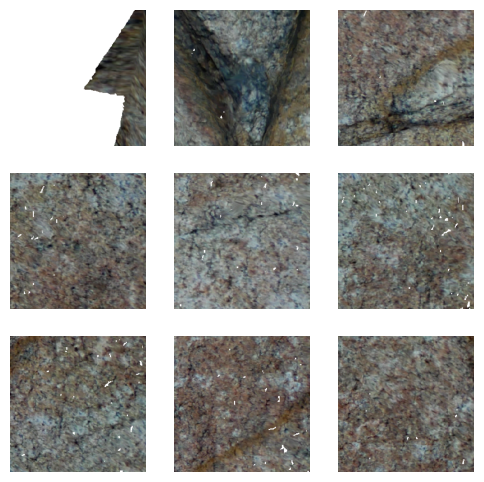

In [9]:
#Lets plot some samples
rows,cols = 3, 3
fig=plt.figure(figsize=(6,6))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path = train_files[i]
    msk_path = train_mask_files[i]
    img = imread(img_path)
    msk = imread(msk_path)
    plt.imshow(img[:, :, :3])
    # plt.imshow(msk,alpha=0.3)
    plt.axis('off')
    plt.grid([])
plt.show()

# **Create data frame and split data on train set, validation set and test set**

In [10]:
df_train = pd.DataFrame(data={"filename": train_files, 'mask' : train_mask_files})
df_test = pd.DataFrame(data={"filename": test_files, 'mask' : test_mask_files})
df_val = pd.DataFrame(data={"filename": valid_files, 'mask' : valid_mask_files})
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2174, 2)
(323, 2)
(912, 2)


In [11]:
df_train.head()

,filename,mask
0,../data/png/train/image/Site_A_1.png,../data/png/train/gt/Site_A_1.png
1,../data/png/train/image/Site_A_10.png,../data/png/train/gt/Site_A_10.png
2,../data/png/train/image/Site_A_100.png,../data/png/train/gt/Site_A_100.png
3,../data/png/train/image/Site_A_1000.png,../data/png/train/gt/Site_A_1000.png
4,../data/png/train/image/Site_A_1001.png,../data/png/train/gt/Site_A_1001.png


# **Data genertator, data augmentation and adjust data**

In [12]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgba",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256, 1),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="filename",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        # preprocessing_function=preprocess,
        seed=seed
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        # preprocessing_function=preprocess,
        seed=seed
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

def adjust_data(img, mask):
    img = img / 255

    mask = mask / 255
    mask[mask > 0.01] = 1
    mask[mask <= 0.01] = 0

    return (img, mask)

# **Define loss function and metrics**

In [13]:
# Take long time
# means = []
# for i, p in enumerate(df_train['mask']):
#     mask = imread(p)
#     _, mask = adjust_data(0, mask)
#     arr = np.where( mask == 1,1,0)
#     means.append(arr.mean())

# non_frac_wt = sum(means)/len(means)
# frac_wt = 1 - non_frac_wt

# frac_wt, non_frac_wt

In [14]:
# (0.9846228184564023, 0.01537718154359763)
non_frac_wt = 0.02
frac_wt = 1 - non_frac_wt

In [15]:
smooth=100

def wt_cross_entropy_loss(y_true,y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    loss = K.mean(-(frac_wt*y_true* K.log(y_pred+1e-7)
                   + non_frac_wt* (1 - y_true) * K.log( 1 - y_pred + 1e-7)))
    #l1=K.mean(-(frac_wt*y_true* K.log(y_pred+1e-7)))
    #l2=K.mean(-(non_frac_wt* (1 - y_true) * K.log( 1 - y_pred + 1e-7)))
    return loss

def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)

    return 1 - iou(y_true, y_pred)

# **FCN Model**

In [16]:
inputs = tf.keras.layers.Input(shape=(256, 256, 4))

In [17]:
def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    return c6

In [18]:
num_classes = 1
def decoder(c6):
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Add()([u7, c7])

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Add()([u8, c8])

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Add()([u9, c9])

    u10 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = tf.keras.layers.Add()([u10, c10])

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c10)
    return outputs

In [19]:
encoder = encoder(inputs)
outputs = decoder(encoder)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

2024-02-16 14:28:50.577059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:e2:00.0, compute capability: 8.0


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         592       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

# **Training**

In [21]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

In [22]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=img_size)

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=img_size)

opt = Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef, 'AUC'])

callbacks = [ModelCheckpoint('models/00-fcn.hdf5', verbose=1, save_best_only=True)]


history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2174 validated image filenames.
Found 2174 validated image filenames.
Epoch 1/100


2024-02-16 14:28:54.609436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-16 14:28:55.130520: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-16 14:28:55.236018: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-16 14:28:56.170558: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-16 14:29:00.405575: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f83d8fd9de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 14:29:00.405633: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 

68/67 [==============================] - ETA: 0s - loss: 0.9654 - binary_accuracy: 0.8071 - iou: 0.0177 - dice_coef: 0.0346 - auc: 0.5400Found 323 validated image filenames.
Found 323 validated image filenames.

Epoch 1: val_loss improved from inf to 0.94843, saving model to models/00-fcn.hdf5
67/67 [==============================] - 70s 741ms/step - loss: 0.9654 - binary_accuracy: 0.8071 - iou: 0.0177 - dice_coef: 0.0346 - auc: 0.5400 - val_loss: 0.9484 - val_binary_accuracy: 0.6441 - val_iou: 0.0247 - val_dice_coef: 0.0480 - val_auc: 0.4221
Epoch 2/100


/work/FAC/FGSE/ISTE/asamsu/detect/frac-map-dl/jlab_venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/67 [==============================] - ETA: 0s - loss: 0.9582 - binary_accuracy: 0.9360 - iou: 0.0215 - dice_coef: 0.0418 - auc: 0.6177
Epoch 2: val_loss improved from 0.94843 to 0.94226, saving model to models/00-fcn.hdf5
67/67 [==============================] - 38s 566ms/step - loss: 0.9582 - binary_accuracy: 0.9360 - iou: 0.0215 - dice_coef: 0.0418 - auc: 0.6177 - val_loss: 0.9423 - val_binary_accuracy: 0.2528 - val_iou: 0.0300 - val_dice_coef: 0.0580 - val_auc: 0.5064
Epoch 3/100
68/67 [==============================] - ETA: 0s - loss: 0.9428 - binary_accuracy: 0.9416 - iou: 0.0299 - dice_coef: 0.0572 - auc: 0.6003
Epoch 3: val_loss improved from 0.94226 to 0.88938, saving model to models/00-fcn.hdf5
67/67 [==============================] - 38s 567ms/step - loss: 0.9428 - binary_accuracy: 0.9416 - iou: 0.0299 - dice_coef: 0.0572 - auc: 0.6003 - val_loss: 0.8894 - val_binary_accuracy: 0.8870 - val_iou: 0.0628 - val_dice_coef: 0.1172 - val_auc: 0.5872
Epoch 4/100
68/67 [===========

In [23]:
with open('history/00-trainHistoryDict_00-fcn', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

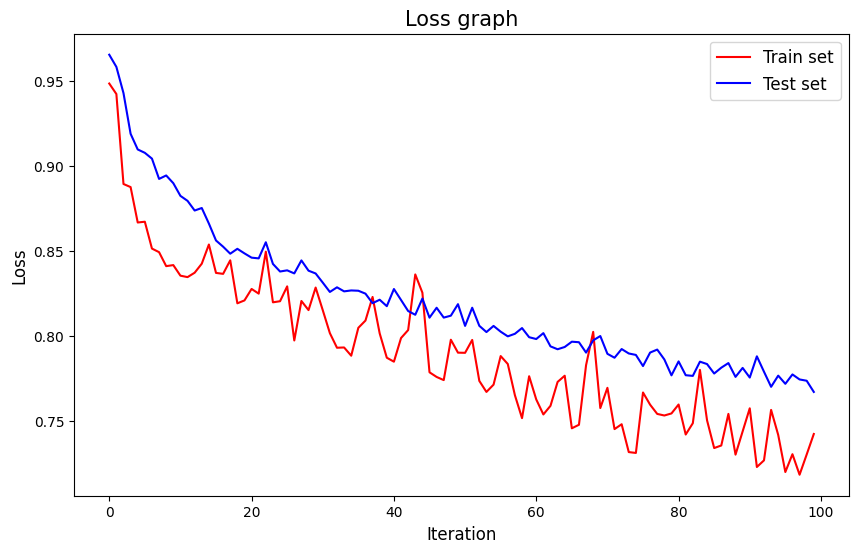

In [24]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(list_testloss, 'r-', label='Train set')
ax.plot(list_trainloss, 'b-', label='Test set')
ax.set_xlabel('Iteration', fontsize = 12)
ax.set_ylabel('Loss', fontsize = 12)
ax.set_title('Loss graph', fontsize = 15)
ax.legend(loc='best', fontsize = 12)

plt.savefig('figs/00-fcn-loss-graph.jpg', dpi=400)

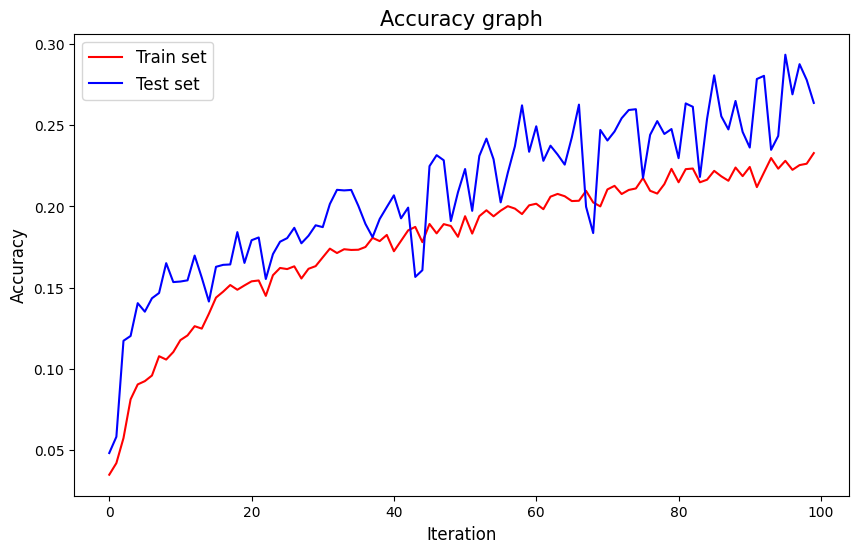

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(list_traindice, 'r-', label='Train set')
ax.plot(list_testdice, 'b-', label='Test set')
ax.set_xlabel('Iteration', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.set_title('Accuracy graph', fontsize = 15)
ax.legend(loc='best', fontsize = 12)
plt.savefig('figs/00-fcn-accuracy-graph.jpg', dpi=400)

In [29]:
model2 = load_model('models/08-unet_dice_rgba.hdf5', custom_objects={'jac_distance': jac_distance, 'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [27]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(img_size[0], img_size[1]))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 912 validated image filenames.
Found 912 validated image filenames.
28/28 [==============================] - 20s 742ms/step - loss: 0.8974 - binary_accuracy: 0.9437 - iou: 0.0548 - dice_coef: 0.1027 - auc: 0.5286
Test loss:  0.8974082469940186
Test IOU:  0.9436957240104675
Test Dice Coefficent:  0.05478229373693466


1/1 [==============================] - 0s 23ms/step


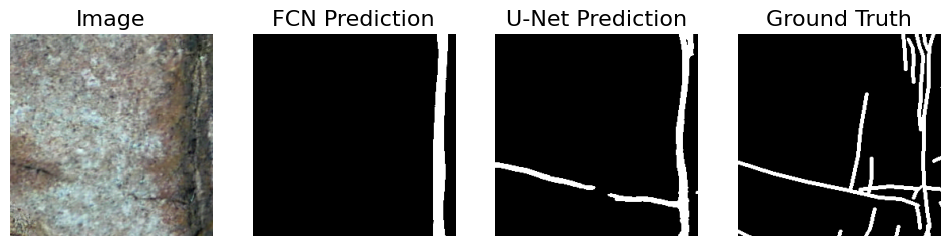

1/1 [==============================] - 0s 22ms/step


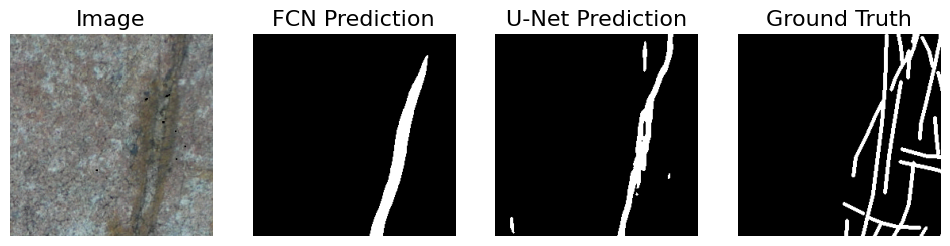

1/1 [==============================] - 0s 23ms/step


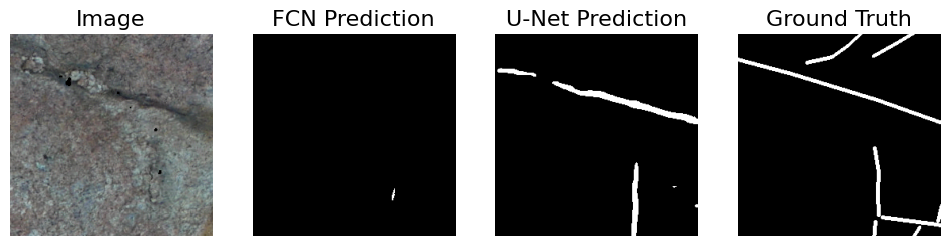

1/1 [==============================] - 0s 22ms/step


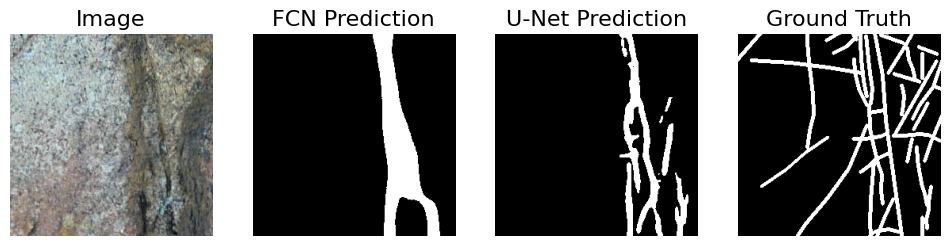

1/1 [==============================] - 0s 23ms/step


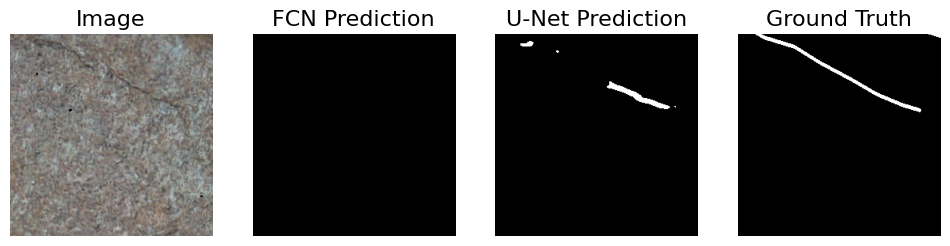

1/1 [==============================] - 0s 22ms/step


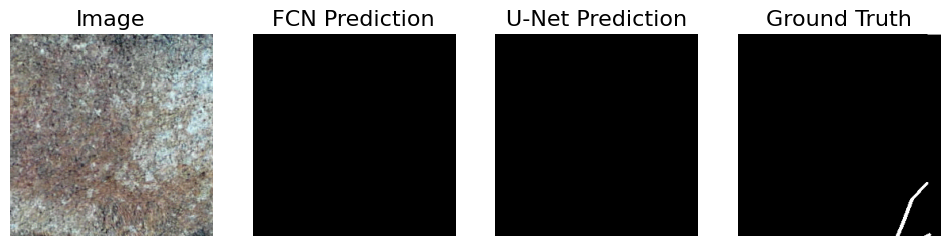

1/1 [==============================] - 0s 22ms/step


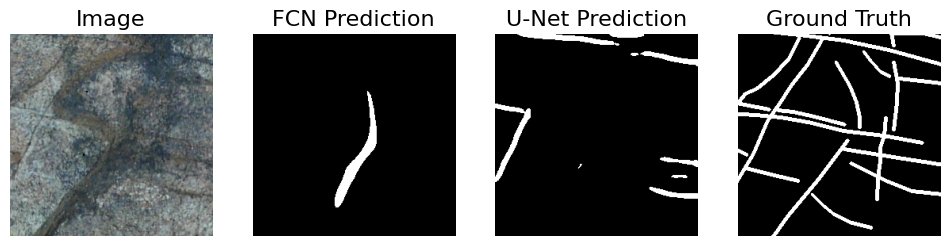

1/1 [==============================] - 0s 22ms/step


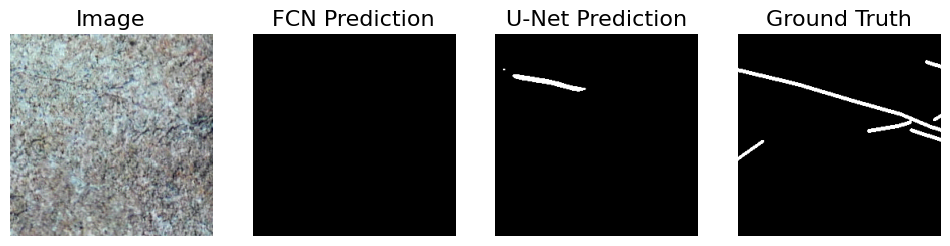

1/1 [==============================] - 0s 22ms/step


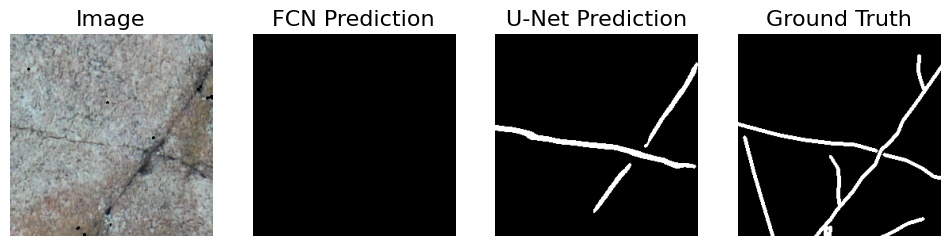

1/1 [==============================] - 0s 22ms/step


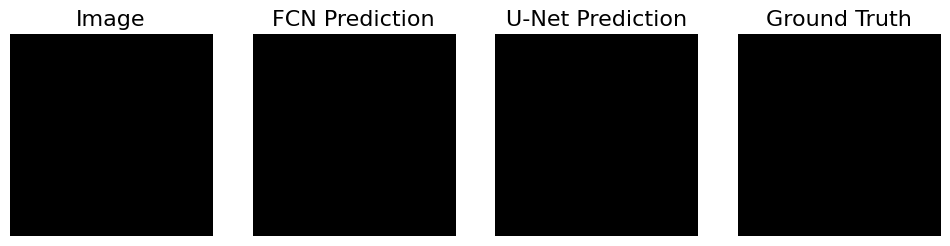

1/1 [==============================] - 0s 23ms/step


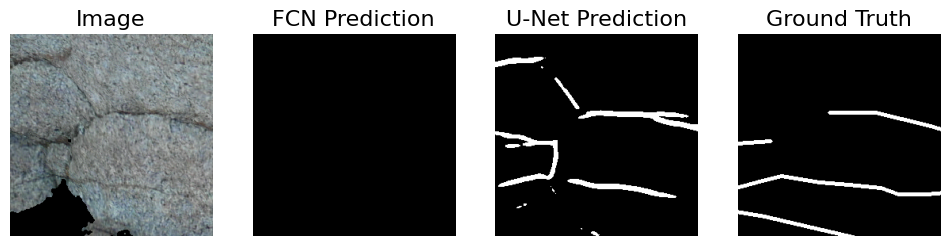

1/1 [==============================] - 0s 22ms/step


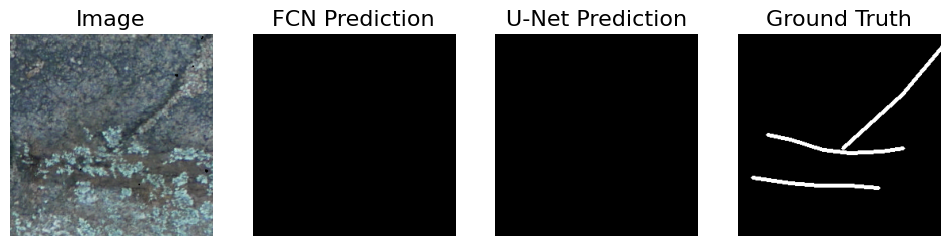

1/1 [==============================] - 0s 22ms/step


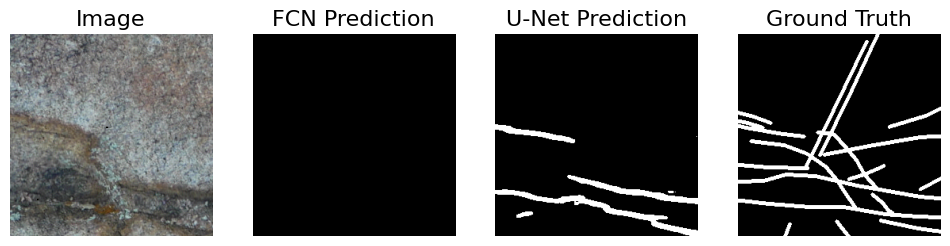

1/1 [==============================] - 0s 22ms/step


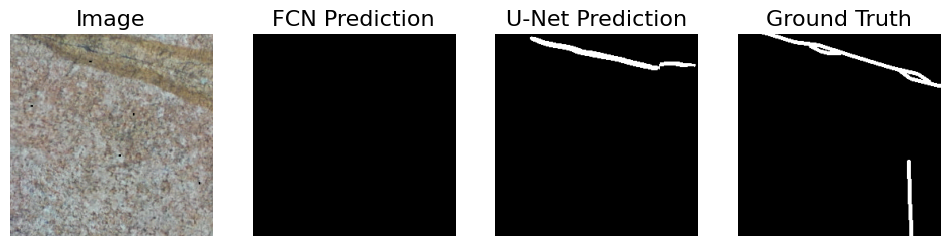

1/1 [==============================] - 0s 22ms/step


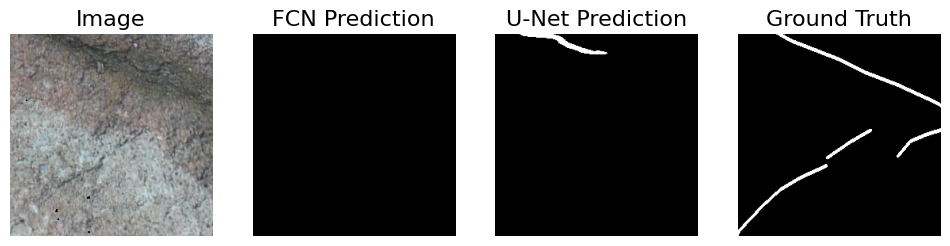

1/1 [==============================] - 0s 22ms/step


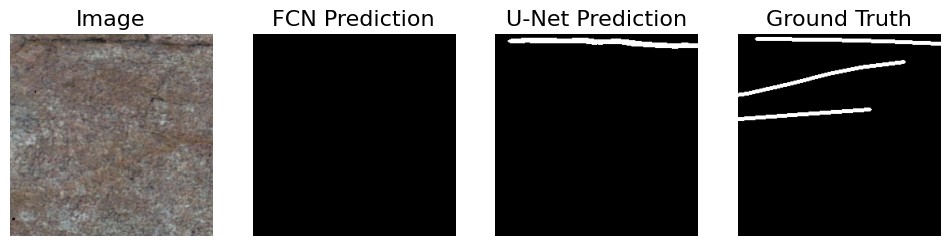

1/1 [==============================] - 0s 23ms/step


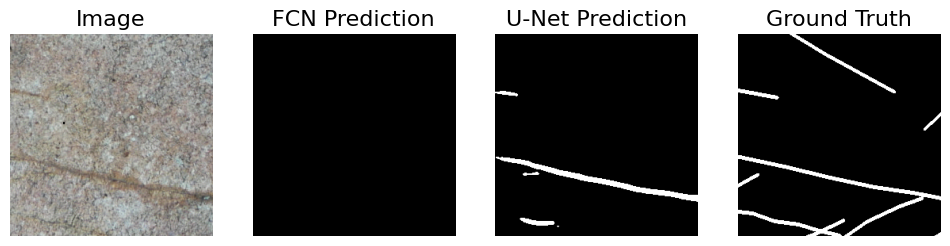

1/1 [==============================] - 0s 23ms/step


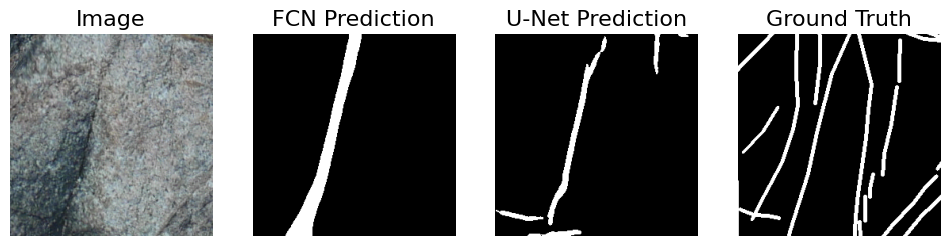

1/1 [==============================] - 0s 23ms/step


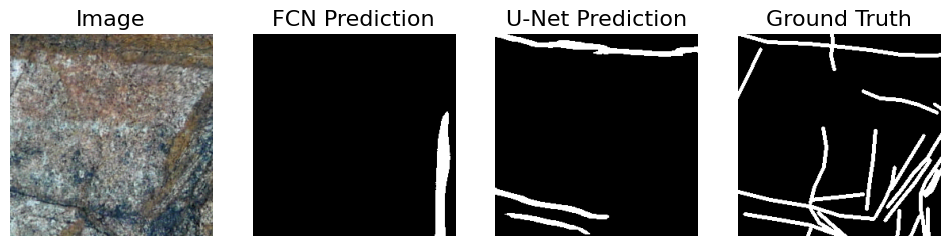

1/1 [==============================] - 0s 22ms/step


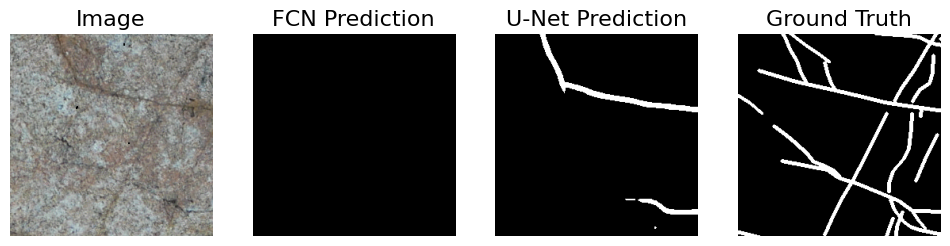

In [34]:
for i in [121, 739, 680, 179, 36, 174, 243, 53, 258, 787, 3, 728, 484, 149, 63, 23, 477, 648, 442, 482]:
    # index=np.random.randint(1,len(df_test.index))
    index = i
    img = imread(df_test['filename'].iloc[index])
    mask = imread(df_test['mask'].iloc[index])
    # adjust img and msk !
    img, mask = adjust_data(img, mask)
    img = img[np.newaxis, :, :, :]
    pred = model.predict(img)
    pred2 = model2.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(imread(df_test['filename'].iloc[index])[:, :, :3]))
    plt.title('Image', fontsize = 16)
    plt.axis('off')
    plt.grid('off')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(pred) > .5, cmap='gray')
    plt.title('FCN Prediction', fontsize = 16)
    plt.axis('off')
    plt.grid('off')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred2) > .5, cmap='gray')
    plt.title('U-Net Prediction', fontsize = 16)
    plt.axis('off')
    plt.grid('off')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(mask), cmap='gray')
    plt.title('Ground Truth', fontsize = 16)
    plt.axis('off')
    plt.grid('off')
    plt.show()
    # break